Cross-shelf transport (total) of NOGMREDI experiments
==

This notebook explores the similarities and differences between the 2 tracer transports for case NOGMREDI as well as canyon and no canyon cases. It looks at the transport normal to a shelf break wall<sup>1</sup>. Total Tracer Transport (TracTrans) is understood here as tracer transport (concentration * transport) per cell area; similarly, Total Transport (Trans) is transport per cell area, which is only the speed. This gives the following units:

$[TracTrans] = [C]ms^{-1} $

$[Trans] = [v] = ms^{-1} $

TracTrans = AdvFlux + DiffFlux / cell area

<sup>1</sup> Plane that goes from shelf-break depth to surface and all along the shelf break.

This experiment was designed to compare to REDI cases mainly. We can explore the effect of horizontal diffusivity, vertical diffuivity and open and closed boundaries.

NOGMREDI runs include the following cases:

| Run   |   $k_{h}$ ($m^2s^{-1}$)  |Tr 01 $k_{v}$ ($m^2s^{-1}$)  |  Bathymetry  |
|:-----:|:------------------------:|:---------------------: |:-----------------------|
|  02   | $10^{-5}$                 | $10^{-5}$  | Barkley-like             |
|  03   | $10^{-5}$                 | $10^{-5}$ | Barkley-like             |
|  04   | $10^{-5}$                | $10^{-5}$ | No Canyon            |
|  05   | $10^{-5}$                 |$10^{-5}$  | Barkley-like w/ walls        |
|  06   | $10^{-5}$                 | $10^{-5}$ | No canyon w/ walls            |
Closed-boundaries experiments to solve discrepancy between total mass on shelf decreasing (canyon effect) and cross-shelf transport being towards the shelf at all times.

In [1]:
#KRM

import numpy as np

import matplotlib.pyplot as plt

import matplotlib.colors as mcolors

from math import *

import scipy.io

import scipy as spy

%matplotlib inline

from netCDF4 import Dataset

import pylab as pl

import os 

import sys

import seaborn as sns

In [2]:
lib_path = os.path.abspath('/ocean/kramosmu/Building_canyon/BuildCanyon/PythonModulesMITgcm') # Add absolute path to my python scripts
sys.path.append(lib_path)

import ReadOutTools_MITgcm as rout 

import ShelfBreakTools_MITgcm as sb

import savitzky_golay as sg

In [3]:
#Base case, iso =1 , No 3d diff.
CanyonGrid='/ocean/kramosmu/MITgcm/TracerExperiments/NOGMREDI/run02/gridGlob.nc'
CanyonGridOut = Dataset(CanyonGrid)
#for dimobj in CanyonGridOut.variables.values():
#    print dimobj
CanyonState='/ocean/kramosmu/MITgcm/TracerExperiments/NOGMREDI/run02/stateGlob.nc'
CanyonStateOut = Dataset(CanyonState)

FluxTR01 = '/ocean/kramosmu/MITgcm/TracerExperiments/NOGMREDI/run02/FluxTR01Glob.nc'
FluxOut1 = Dataset(FluxTR01)

CanyonGridNoC='/ocean/kramosmu/MITgcm/TracerExperiments/NOGMREDI/run04/gridGlob.nc'
CanyonGridOutNoC = Dataset(CanyonGridNoC)

CanyonStateNoC='/ocean/kramosmu/MITgcm/TracerExperiments/NOGMREDI/run04/stateGlob.nc'

FluxTR01NoC = '/ocean/kramosmu/MITgcm/TracerExperiments/NOGMREDI/run04/FluxTR01Glob.nc'
FluxTR03NoC = '/ocean/kramosmu/MITgcm/TracerExperiments/NOGMREDI/run04/FluxTR03Glob.nc'

In [4]:
# General input
nx = 360
ny = 360
nz = 90
nt = 19 # t dimension size 

z = CanyonStateOut.variables['Z']
#print(z[10])
Time = CanyonStateOut.variables['T']
#print(Time[:])

xc = rout.getField(CanyonGrid, 'XC') # x coords tracer cells

yc = rout.getField(CanyonGrid, 'YC') # y coords tracer cells

bathy = rout.getField(CanyonGrid, 'Depth')

hFacC = rout.getField(CanyonGrid, 'HFacC')
MaskC = rout.getMask(CanyonGrid, 'HFacC')

hFacCNoC = rout.getField(CanyonGridNoC, 'HFacC')
MaskCNoC = rout.getMask(CanyonGridNoC, 'HFacC')

rA = rout.getField(CanyonGrid, 'rA')

dyF = rout.getField(CanyonGrid, 'dyF')
dxF = rout.getField(CanyonGrid, 'dxF')
drF = CanyonGridOut.variables['drF']

In [5]:
sns.set()
sns.set_style('white')
sns.set_context('talk')

In [6]:
colors=['midnightblue','dodgerblue','deepskyblue','lightskyblue',
        'darkmagenta','orchid']

In [7]:
#VTRAC = rout.getField(FluxTR01,'VTRAC01') # 
#UTRAC = rout.getField(FluxTR01,'UTRAC01') # 

#VTRACNoC = rout.getField(FluxTR01NoC,'VTRAC01') # 
#UTRACNoC = rout.getField(FluxTR01NoC,'UTRAC01') # 

VTRAC = rout.getField(FluxTR01,'ADVyTr01') # 
UTRAC = rout.getField(FluxTR01,'ADVxTr01') # 

VTRACNoC = rout.getField(FluxTR01NoC,'ADVyTr01') # 
UTRACNoC = rout.getField(FluxTR01NoC,'ADVxTr01') # 


In [16]:
VTRACDif = rout.getField(FluxTR01,'DFyETr01') # 
UTRACDif = rout.getField(FluxTR01,'DFxETr01') # 

VTRACNoCDif = rout.getField(FluxTR01NoC,'DFyETr01') # 
UTRACNoCDif = rout.getField(FluxTR01NoC,'DFxETr01') # 


In [44]:
zlev = 30
SBx, SBy = sb.findShelfBreak(zlev,hFacC)
SBxx = SBx[:-1]
SByy = SBy[:-1]
slope, theta = sb.findSlope(xc,yc,SBxx,SByy)
slopeFilt = sg.savitzky_golay(slope, 11, 3) # window size 11, polynomial order 3
thetaFilt = np.arctan(slopeFilt)

zlev = 30
SBxNoC, SByNoC = sb.findShelfBreak(zlev,hFacCNoC)
SBxxNoC = SBxNoC[:-1]
SByyNoC = SByNoC[:-1]
slopeNoC, thetaNoC = sb.findSlope(xc,yc,SBxxNoC,SByyNoC)
slopeFiltNoC = sg.savitzky_golay(slopeNoC, 11, 3) # window size 11, polynomial order 3
thetaFiltNoC = np.arctan(slopeFiltNoC)


In [45]:
# Vert transport
#WTRAC = rout.getField(FluxTR01,'WTRAC01') # 
WTRAC = rout.getField(FluxTR01,'ADVrTr01') # 


In [17]:
WTRACdife = rout.getField(FluxTR01,'DFrETr01') # 
WTRACdifi = rout.getField(FluxTR01,'DFrITr01') # 


In [46]:
AreaFlatU = sb.AreaYface(hFacCNoC,drF,dyF,zlev)
AreaFlatV = sb.AreaXface(hFacCNoC,drF,dxF,zlev)

AreaSBU = sb.AreaYface(hFacC,drF,dyF,zlev)
AreaSBV = sb.AreaXface(hFacC,drF,dxF,zlev)


#AreaFlatV =  AreaFlat[:,4:-5]*np.cos(thetaFilt) 
#AreaFlatU =  AreaFlat[:,4:-5]*np.sin(-thetaFilt) 

#AreaCanyonWall = sb.AreaWallSB(hFacC,drF,dxF,zlev)
#AreaSBV =  AreaCanyonWall[:,4:-5]*np.cos(thetaFilt) 
#AreaSBU =  AreaCanyonWall[:,4:-5]*np.sin(-thetaFilt) 

AreaLid = np.ma.masked_array(rA[230:,:], mask=MaskC[29,230:,:])

### Calculation along shelf-break walls and along flat shelf

In [47]:
times = range(18)

ToTalTracTransBaseNoC=np.empty(18)
ToTalTracTransBase=np.empty(18)
ToTalTracTransBaseFlat=np.empty(18)
ToTalTracTransBaseNoCSB=np.empty(18)

    
  
for tt in times:
    
    VTRACPlotBase = sb.MerFluxSB(SBxx,SByy,tt,VTRAC,z,xc,zlev,hFacC,MaskC)
    UTRACPlotBase = sb.ZonFluxSB(SBxx,SByy,tt,UTRAC,z,xc,zlev,hFacC,MaskC)
    
    VTRACPlotNoC = sb.MerFluxSB(SBxxNoC,SByyNoC,tt,VTRACNoC,z,xc,zlev,hFacCNoC,MaskCNoC)
    UTRACPlotNoC = sb.ZonFluxSB(SBxxNoC,SByyNoC,tt,UTRACNoC,z,xc,zlev,hFacCNoC,MaskCNoC)
    
    VTRACPlotBaseFlat = sb.MerFluxSB(SBxxNoC,SByyNoC,tt,VTRAC,z,xc,zlev,hFacCNoC,MaskCNoC)
    UTRACPlotBaseFlat = sb.ZonFluxSB(SBxxNoC,SByyNoC,tt,UTRAC,z,xc,zlev,hFacCNoC,MaskCNoC)
    
    VTRACPlotNoCSB = sb.MerFluxSB(SBxx,SByy,tt,VTRACNoC,z,xc,zlev,hFacC,MaskC)
    UTRACPlotNoCSB = sb.ZonFluxSB(SBxx,SByy,tt,UTRACNoC,z,xc,zlev,hFacC,MaskC)
    
    # No area calc
    TracTransNoC =  VTRACPlotNoC[:,4:-5]*np.cos(thetaFiltNoC) + UTRACPlotNoC[:,4:-4]*np.sin(-thetaFiltNoC) 
    TracTransBase =  VTRACPlotBase[:,4:-5]*np.cos(thetaFilt) + UTRACPlotBase[:,4:-4]*np.sin(-thetaFilt) 
    TracTransBaseFlat =  VTRACPlotBaseFlat[:,4:-5]*np.cos(thetaFiltNoC) + UTRACPlotBaseFlat[:,4:-4]*np.sin(-thetaFiltNoC) 
    TracTransNoCSB =  VTRACPlotNoCSB[:,4:-5]*np.cos(thetaFilt) + UTRACPlotNoCSB[:,4:-4]*np.sin(-thetaFilt) 
    
    #TracTransNoC =  VTRACPlotNoC[:,4:-5]*np.cos(thetaFiltNoC)*AreaFlatV[:,4:-5] + UTRACPlotNoC[:,4:-4]*np.sin(-thetaFiltNoC)*AreaFlatU[:,4:-5]
    
    #TracTransBase =  VTRACPlotBase[:,4:-5]*np.cos(thetaFilt)*AreaSBV[:,4:-5] + UTRACPlotBase[:,4:-4]*np.sin(-thetaFilt)*AreaSBU[:,4:-5]
    #TracTransBaseFlat =  VTRACPlotBaseFlat[:,4:-5]*np.cos(thetaFiltNoC)*AreaFlatV[:,4:-5] + UTRACPlotBaseFlat[:,4:-4]*np.sin(-thetaFiltNoC)*AreaFlatU[:,4:-5] 
    #TracTransNoCSB =  VTRACPlotNoCSB[:,4:-5]*np.cos(thetaFilt)*AreaSBV[:,4:-5] + UTRACPlotNoCSB[:,4:-4]*np.sin(-thetaFilt)*AreaSBU[:,4:-5]
    
    ToTalTracTransBase[tt]=np.sum(TracTransBase)
    ToTalTracTransBaseNoC[tt]=np.sum(TracTransNoC)
    ToTalTracTransBaseFlat[tt]=np.sum(TracTransBaseFlat)
    ToTalTracTransBaseNoCSB[tt]=np.sum(TracTransNoCSB)
    

In [48]:
# Vertical transport

mask_expand = np.expand_dims(MaskC[30,230:,:],0)
mask_expand = mask_expand + np.zeros(WTRAC[:,30,230:,:].shape)

vert = WTRAC[:,30,230:,:]

#vert = WTRAC[:,29,230:,:]*AreaLid
VertTrans= np.sum(np.sum(np.ma.masked_array(vert,mask = mask_expand),axis=1),axis=1)

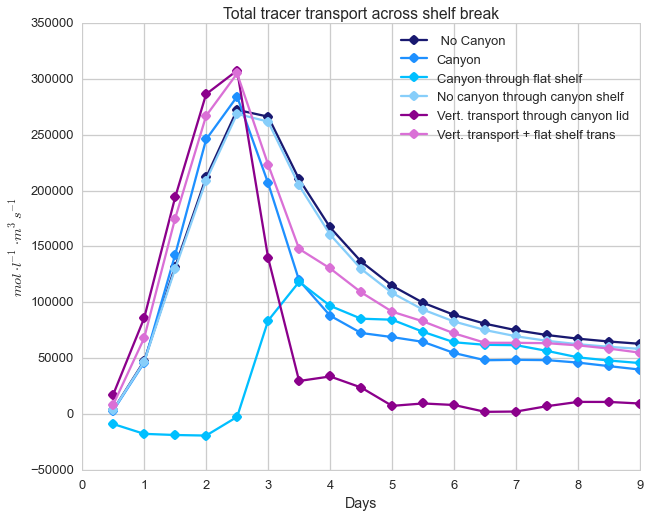

In [49]:
sns.set(context='talk', style='whitegrid', font='sans-serif', font_scale=1)

times = range(18)# # First time element of flux is at 43200 sec, and las at 8 days 
times = [time/2.0+0.5 for time in times]

figSize=(10,8)
numCols = 1
numRows = 1

unitsTr = '$mol \cdot l^{-1}\cdot m^3s^{-1}$'


fig44 = plt.figure(figsize=figSize)
plt.subplot(numRows,numCols,1)
ax = plt.gca()
ax.plot(times,ToTalTracTransBaseNoC[:],'o-',color=colors[0],label = ' No Canyon')    
ax.plot(times,ToTalTracTransBase[:],'o-',color=colors[1],label = 'Canyon')
ax.plot(times,ToTalTracTransBaseFlat[:],'o-',color=colors[2],label = 'Canyon through flat shelf')
ax.plot(times,ToTalTracTransBaseNoCSB[:],'o-',color=colors[3],label = 'No canyon through canyon shelf')
ax.plot(times,VertTrans[:],'o-',color=colors[4],label = 'Vert. transport through canyon lid')
ax.plot(times,VertTrans[:]+ToTalTracTransBaseFlat[:],'o-',color=colors[5],label = 'Vert. transport + flat shelf trans')

handles, labels = ax.get_legend_handles_labels()
display = (0,1,2,3,4,5)
ax.legend([handle for i,handle in enumerate(handles) if i in display],
          [label for i,label in enumerate(labels) if i in display],loc=0)
   
    
plt.xlabel('Days')
plt.ylabel(unitsTr)
plt.title('Total tracer transport across shelf break')
    

74711667.7196
17977896.0


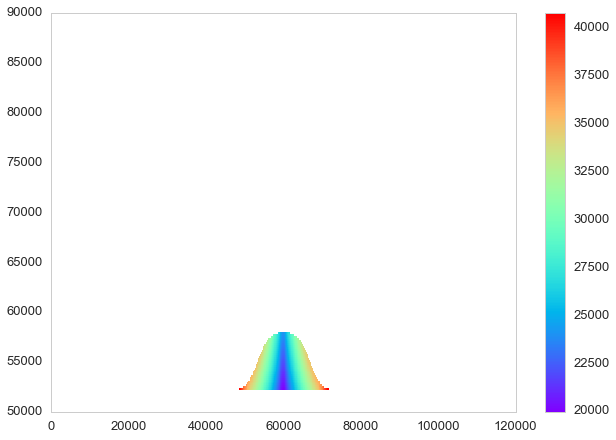

In [50]:
plt.pcolor(xc[230:,:],yc[230:,:],AreaLid,cmap = 'rainbow')
plt.colorbar()
print(np.sum(AreaLid))
print(np.sum(AreaFlatV))

<matplotlib.colorbar.Colorbar instance at 0x7f155f3dd950>

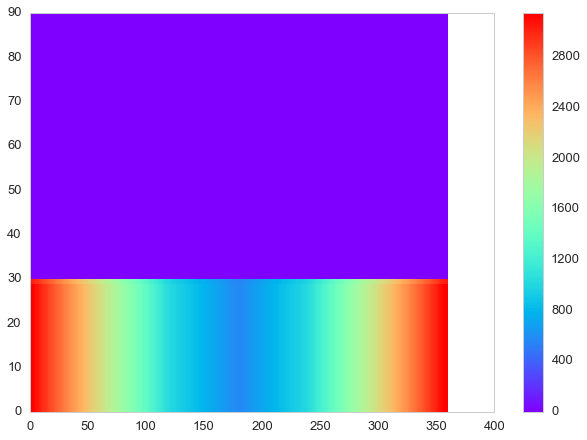

In [51]:
plt.pcolor(AreaFlatV,cmap = 'rainbow')
plt.colorbar()


In [52]:
times = range(18)

ToTalTracTransDifBaseNoC=np.empty(18)
ToTalTracTransDifBase=np.empty(18)
ToTalTracTransDifBaseFlat=np.empty(18)
ToTalTracTransDifBaseNoCSB=np.empty(18)

    
  
for tt in times:
    
    VTRACPlotBase = sb.MerFluxSB(SBxx,SByy,tt,VTRACDif,z,xc,zlev,hFacC,MaskC)
    UTRACPlotBase = sb.ZonFluxSB(SBxx,SByy,tt,UTRACDif,z,xc,zlev,hFacC,MaskC)
    
    VTRACPlotNoC = sb.MerFluxSB(SBxxNoC,SByyNoC,tt,VTRACNoCDif,z,xc,zlev,hFacCNoC,MaskCNoC)
    UTRACPlotNoC = sb.ZonFluxSB(SBxxNoC,SByyNoC,tt,UTRACNoCDif,z,xc,zlev,hFacCNoC,MaskCNoC)
    
    VTRACPlotBaseFlat = sb.MerFluxSB(SBxxNoC,SByyNoC,tt,VTRACDif,z,xc,zlev,hFacCNoC,MaskCNoC)
    UTRACPlotBaseFlat = sb.ZonFluxSB(SBxxNoC,SByyNoC,tt,UTRACDif,z,xc,zlev,hFacCNoC,MaskCNoC)
    
    
    VTRACPlotNoCSB = sb.MerFluxSB(SBxx,SByy,tt,VTRACNoCDif,z,xc,zlev,hFacC,MaskC)
    UTRACPlotNoCSB = sb.ZonFluxSB(SBxx,SByy,tt,UTRACNoCDif,z,xc,zlev,hFacC,MaskC)
    
    # No area calc
    TracTransNoC =  VTRACPlotNoC[:,4:-5]*np.cos(thetaFiltNoC) + UTRACPlotNoC[:,4:-4]*np.sin(-thetaFiltNoC) 
    TracTransBase =  VTRACPlotBase[:,4:-5]*np.cos(thetaFilt) + UTRACPlotBase[:,4:-4]*np.sin(-thetaFilt) 
    TracTransBaseFlat =  VTRACPlotBaseFlat[:,4:-5]*np.cos(thetaFiltNoC) + UTRACPlotBaseFlat[:,4:-4]*np.sin(-thetaFiltNoC) 
    TracTransNoCSB =  VTRACPlotNoCSB[:,4:-5]*np.cos(thetaFilt) + UTRACPlotNoCSB[:,4:-4]*np.sin(-thetaFilt) 
    
    #TracTransNoC =  VTRACPlotNoC[:,4:-5]*np.cos(thetaFiltNoC)*AreaFlatV[:,4:-5] + UTRACPlotNoC[:,4:-4]*np.sin(-thetaFiltNoC)*AreaFlatU[:,4:-5]
    
    #TracTransBase =  VTRACPlotBase[:,4:-5]*np.cos(thetaFilt)*AreaSBV[:,4:-5] + UTRACPlotBase[:,4:-4]*np.sin(-thetaFilt)*AreaSBU[:,4:-5]
    #TracTransBaseFlat =  VTRACPlotBaseFlat[:,4:-5]*np.cos(thetaFiltNoC)*AreaFlatV[:,4:-5] + UTRACPlotBaseFlat[:,4:-4]*np.sin(-thetaFiltNoC)*AreaFlatU[:,4:-5] 
    #TracTransNoCSB =  VTRACPlotNoCSB[:,4:-5]*np.cos(thetaFilt)*AreaSBV[:,4:-5] + UTRACPlotNoCSB[:,4:-4]*np.sin(-thetaFilt)*AreaSBU[:,4:-5]
    
    ToTalTracTransDifBase[tt]=np.sum(TracTransBase)
    ToTalTracTransDifBaseNoC[tt]=np.sum(TracTransNoC)
    ToTalTracTransDifBaseFlat[tt]=np.sum(TracTransBaseFlat)
    ToTalTracTransDifBaseNoCSB[tt]=np.sum(TracTransNoCSB)
    

In [53]:
# Vertical transport

mask_expand = np.expand_dims(MaskC[29,230:,:],0)
mask_expand = mask_expand + np.zeros(WTRACdife[:,29,230:,:].shape)

vert = WTRACdifi[:,29,230:,:]

#vert = WTRAC[:,29,230:,:]*AreaLid
VertTransDif= np.sum(np.sum(np.ma.masked_array(vert,mask = mask_expand),axis=1),axis=1)

In [54]:
mask_expand2 = np.expand_dims(MaskC[:30,230,:],0)
mask_expand2 = mask_expand2 + np.zeros(VTRAC[:,:30,230,:].shape)

#vert = WTRAC[:,29,230:,:]*AreaLid
VTRACBaseFlat= np.sum(np.sum(np.ma.masked_array(VTRAC[:,:30,230,:],mask = mask_expand2),axis=1),axis=1)


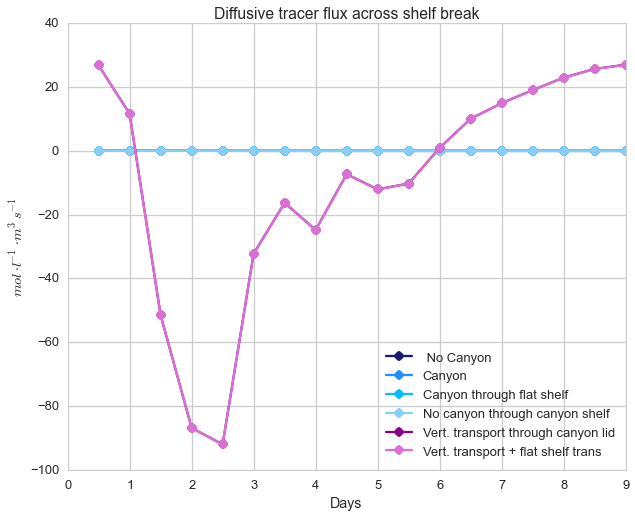

In [55]:
sns.set(context='talk', style='whitegrid', font='sans-serif', font_scale=1)

times = range(18)# # First time element of flux is at 43200 sec, and las at 8 days 
times = [time/2.0+0.5 for time in times]

figSize=(10,8)
numCols = 1
numRows = 1

unitsTr = '$mol \cdot l^{-1}\cdot m^3s^{-1}$'


fig44 = plt.figure(figsize=figSize)
plt.subplot(numRows,numCols,1)
ax = plt.gca()
ax.plot(times,ToTalTracTransDifBaseNoC[:],'o-',color=colors[0],label = ' No Canyon')    
ax.plot(times,ToTalTracTransDifBase[:],'o-',color=colors[1],label = 'Canyon')
ax.plot(times,ToTalTracTransDifBaseFlat[:],'o-',color=colors[2],label = 'Canyon through flat shelf')
ax.plot(times,ToTalTracTransDifBaseNoCSB[:],'o-',color=colors[3],label = 'No canyon through canyon shelf')
ax.plot(times,VertTransDif[:],'o-',color=colors[4],label = 'Vert. transport through canyon lid')
ax.plot(times,VertTransDif[:]+ToTalTracTransDifBaseFlat[:],'o-',color=colors[5],label = 'Vert. transport + flat shelf trans')

handles, labels = ax.get_legend_handles_labels()
display = (0,1,2,3,4,5)
ax.legend([handle for i,handle in enumerate(handles) if i in display],
          [label for i,label in enumerate(labels) if i in display],loc=0)
   
    
plt.xlabel('Days')
plt.ylabel(unitsTr)
plt.title('Diffusive tracer flux across shelf break')
    

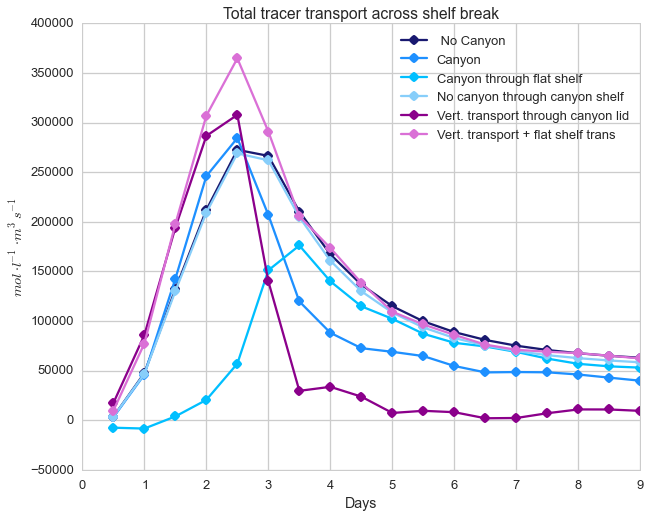

In [56]:
sns.set(context='talk', style='whitegrid', font='sans-serif', font_scale=1)

times = range(18)# # First time element of flux is at 43200 sec, and las at 8 days 
times = [time/2.0+0.5 for time in times]

figSize=(10,8)
numCols = 1
numRows = 1

unitsTr = '$mol \cdot l^{-1}\cdot m^3s^{-1}$'


fig44 = plt.figure(figsize=figSize)
plt.subplot(numRows,numCols,1)
ax = plt.gca()
ax.plot(times,ToTalTracTransBaseNoC[:],'o-',color=colors[0],label = ' No Canyon')    
ax.plot(times,ToTalTracTransBase[:],'o-',color=colors[1],label = 'Canyon')
ax.plot(times,VTRACBaseFlat[:],'o-',color=colors[2],label = 'Canyon through flat shelf')
ax.plot(times,ToTalTracTransBaseNoCSB[:],'o-',color=colors[3],label = 'No canyon through canyon shelf')
ax.plot(times,VertTrans[:],'o-',color=colors[4],label = 'Vert. transport through canyon lid')
ax.plot(times,VertTrans[:]+VTRACBaseFlat[:],'o-',color=colors[5],label = 'Vert. transport + flat shelf trans')

handles, labels = ax.get_legend_handles_labels()
display = (0,1,2,3,4,5)
ax.legend([handle for i,handle in enumerate(handles) if i in display],
          [label for i,label in enumerate(labels) if i in display],loc=0)
   
    
plt.xlabel('Days')
plt.ylabel(unitsTr)
plt.title('Total tracer transport across shelf break')
    

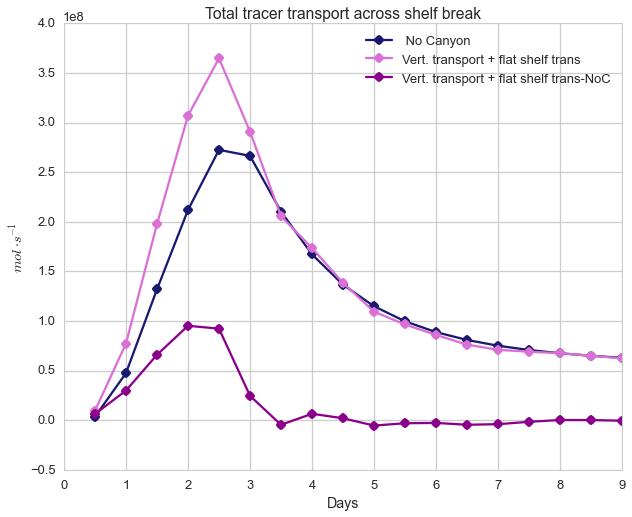

In [62]:
sns.set(context='talk', style='whitegrid', font='sans-serif', font_scale=1)

times = range(18)# # First time element of flux is at 43200 sec, and las at 8 days 
times = [time/2.0+0.5 for time in times]

figSize=(10,8)
numCols = 1
numRows = 1

unitsTr = '$mol \cdot s^{-1}$'


fig44 = plt.figure(figsize=figSize)
plt.subplot(numRows,numCols,1)
ax = plt.gca()
ax.plot(times,ToTalTracTransBaseNoC[:]*1000.0,'o-',color=colors[0],label = ' No Canyon')    
#ax.plot(times,ToTalTracTransBase[:],'o-',color=colors[1],label = 'Canyon')
#ax.plot(times,VTRACBaseFlat[:],'o-',color=colors[2],label = 'Canyon through flat shelf')
#ax.plot(times,ToTalTracTransBaseNoCSB[:],'o-',color=colors[3],label = 'No canyon through canyon shelf')
#ax.plot(times,VertTrans[:],'o-',color=colors[4],label = 'Vert. transport through canyon lid')
ax.plot(times,(VertTrans[:]+VTRACBaseFlat[:])*1000.0,'o-',color=colors[5],label = 'Vert. transport + flat shelf trans')
ax.plot(times,(VertTrans[:]+VTRACBaseFlat[:]-ToTalTracTransBaseNoC[:])*1000.0,'o-',color=colors[4],label = 'Vert. transport + flat shelf trans-NoC')

handles, labels = ax.get_legend_handles_labels()
display = (0,1,2,3,4,5)
ax.legend([handle for i,handle in enumerate(handles) if i in display],
          [label for i,label in enumerate(labels) if i in display],loc=0)
   
    
plt.xlabel('Days')
plt.ylabel(unitsTr)
plt.title('Total tracer transport across shelf break')
    

In [63]:
print(ToTalTracTransBaseNoC[:]*1000.0)

[  3.37773303e+06   4.73685671e+07   1.31848364e+08   2.11831528e+08
   2.72422341e+08   2.66361248e+08   2.10255410e+08   1.67075627e+08
   1.36498783e+08   1.14798331e+08   9.95677298e+07   8.86948997e+07
   8.07910236e+07   7.49806244e+07   7.06448397e+07   6.73897414e+07
   6.48496811e+07   6.28094820e+07]


In [64]:
print((VertTrans[:]+VTRACBaseFlat[:])*1000.0)

[9479984.0 77184560.0 197686208.0 306900480.0 364642560.0 290851296.0
 205525984.0 173459632.0 138356432.0 109291600.0 96380912.0 85873552.0
 76085392.0 70870376.0 68918000.0 67473680.0 64891548.0 62190096.0]


In [65]:
print((VertTrans[:]+VTRACBaseFlat[:]-ToTalTracTransBaseNoC[:])*1000.0)

[6102251.341551542 29815995.446145535 65837839.1296491 95068940.8607781
 92220221.23381495 24490032.972931862 -4729425.451099873 6383997.936427593
 1857654.600083828 -5506729.166463017 -3186815.7643675804
 -2821345.0141251087 -4705632.964450866 -4110249.3989914656
 -1726839.6974131465 83938.29432874918 41865.783113986254
 -619384.3586333096]
